<a href="https://colab.research.google.com/github/em-chiu/intersection_project/blob/main/EC%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import urllib.request
from nltk.corpus import stopwords
import re
import numpy as np
from collections import Counter
from sklearn import preprocessing
import string
nltk.download('averaged_perceptron_tagger') # to solve pos feature extract issue
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import pandas as pd # data processing
import csv
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
import sys
from nltk.tokenize import WordPunctTokenizer
import unidecode
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/emilychiu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilychiu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load the data into list, try1

# racistfile = open("FTR_new_labels.csv", encoding='latin-1', "r")
# racistdata = list(csv.reader(racistfile, delimiter=","))
# racistfile.close()

In [3]:
# load the data into list, try2
# with open('FTR_new_labels.csv', newline='', encoding='latin-1') as csvfile:
#     csv_reader = list(csv.reader(csvfile, delimiter='|'))
#     print(csv_reader)

In [4]:
# import os
# data_dir = '../data/'
# or_fname = 'FTR_new_labels.csv'
# fname = data_dir+or_fname


# load the data to df, try1 works
df = pd.read_csv('FTR_labels_copy.csv', header=None, encoding = "ISO-8859-1")\
        .drop(0, axis=1)\
        .rename(columns={1: 'tweet'})

In [5]:
# load the data to df, try2
# data = '/intersection_project/FTR_new_labels.csv'
# df_racism = pd.read_csv(data, header=None, sep=',\s')

In [6]:
# trying to convert to string
# df_string = df.to_csv('FTR_new_labels.csv')

In [7]:
# preview data
df.head()

,tweet,2
0,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0


In [8]:
# Drop first row 
# by selecting all rows from first row onwards
df = df.iloc[1: , :]

In [9]:
# view dimensions of dataset
df.shape
# 2857 instances and 2 attributes in dataset

(2856, 2)

In [10]:
# Rename column names
col_names = ['tweet', 'label']
df.columns = col_names
df.columns

Index(['tweet', 'label'], dtype='object')

In [11]:
# preview after renaming
df.head()

,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0
5,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1


In [12]:
# summary of data
df.info()
# no missing data
# Categorical variables have data type object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 1 to 2856
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2856 non-null   object
 1   label   2856 non-null   object
dtypes: object(2)
memory usage: 44.8+ KB


In [13]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 2 categorical variables

The categorical variables are :

 ['tweet', 'label']


In [14]:
# view the categorical variables
df[categorical].head()

,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0
5,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1


In [15]:
# check missing values in categorical variables
df[categorical].isnull().sum()

tweet    0
label    0
dtype: int64

In [16]:
# view frequency counts of values in categorical variables
for var in categorical: 
    print(df[var].value_counts())

# 0        1929
# 1         927

"0. Moi\n                                                                                                                                                    4
@flo__lfc @leo2saucisson @ActuFoot_ CrÃ¨ve                                                                                                                   2
"ððððð\n                                                                                                                                      2
"""A Bright Room Called Day"", la cinglante leÃ§on d'histoire de Tony Kushner. Ma critique dans Les SoirÃ©es de Paris â¶ï¸Â https://t.co/Ydl1PqJv7AÂ \n    2
"En ce moment sur LFM #CrÃ¨ve-cÅur#Mauvais Åil et toujours Le Morning sur LFM de 07h Ã  10h du Lundi au Vendredi.\n                                        2
                                                                                                                                                            ..
de toutes faÃ§ons, c'est une mascarade. person

In [17]:
# view frequency distribution of categorical variables
for var in categorical:   
    print(df[var].value_counts()/float(len(df)))

"0. Moi\n                                                                                                                                                    0.001401
@flo__lfc @leo2saucisson @ActuFoot_ CrÃ¨ve                                                                                                                   0.000700
"ððððð\n                                                                                                                                      0.000700
"""A Bright Room Called Day"", la cinglante leÃ§on d'histoire de Tony Kushner. Ma critique dans Les SoirÃ©es de Paris â¶ï¸Â https://t.co/Ydl1PqJv7AÂ \n    0.000700
"En ce moment sur LFM #CrÃ¨ve-cÅur#Mauvais Åil et toujours Le Morning sur LFM de 07h Ã  10h du Lundi au Vendredi.\n                                        0.000700
                                                                                                                                                               ...   
de t

In [18]:
# # check frequency distribution of values in label variable
df.label.value_counts()

0    1929
1     927
Name: label, dtype: int64

In [19]:
# dfobject=df.applymap(str)
# print(dfobject.dtypes)
# # convert df to string

In [20]:
# dfstring=df.to_string
# convert df to string

In [21]:
# datalist = df.values.tolist()
# # data as list to feed into features functions
# print(datalist)

In [22]:
# df_tweet = df['tweet'].astype('string')
# df_label = df['label'].astype('string')

# df.dtypes

In [23]:
# .astype(str) and .astype('str') keep the column as object
df_tweet = df['tweet'].astype(pd.StringDtype())
df_label = df['label'].astype(pd.StringDtype())
# https://stackoverflow.com/questions/60581893/convert-object-data-type-to-string-issue-in-python
df.dtypes

tweet    object
label    object
dtype: object

In [24]:
# some entries were saved as float. This function gest rid of the problem.
def to_string(text):
    if type(text)==float:
        text = str(text)
    return text

In [25]:
colstr_tweet = to_string(df_tweet)
colstr_tweet

1       Elle ne devait pas dÃ©gager la nazi ??? https:...
2       je dois faire un oral en anglais sur Hitler et...
3       @ambrassmoi_ A Ã§a ð¤ de ressembler Ã  la cr...
4       "Par curiositÃ©, jâai voulu Ã©couter les dis...
5       @tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...
                              ...                        
2852                           Kevin câest un sal noir.
2853    bougnoule bamboula sale arabe , elle est belle...
2854      @B_mahrezz Tu viens de le traiter de sal noir ?
2855                     SAL NOIR https://t.co/JraABFtel8
2856    Sal Noir https://t.co/9Sr7f4Mzr5 https://t.co/...
Name: tweet, Length: 2856, dtype: string

In [26]:
stringdf = to_string(df)
stringdf

,tweet,label
1,Elle ne devait pas dÃ©gager la nazi ??? https:...,1
2,je dois faire un oral en anglais sur Hitler et...,0
3,@ambrassmoi_ A Ã§a ð¤ de ressembler Ã la cr...,0
4,"""Par curiositÃ©, jâai voulu Ã©couter les dis...",0
5,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1
...,...,...
2852,Kevin câest un sal noir.,1
2853,"bougnoule bamboula sale arabe , elle est belle...",1
2854,@B_mahrezz Tu viens de le traiter de sal noir ?,1
2855,SAL NOIR https://t.co/JraABFtel8,1


In [27]:
# create a list of corresponding labels
notracist_labels = [0] * 1929 # length of nonracist labels + header
racist_labels = [1] * 927
all_labels = notracist_labels + racist_labels

In [28]:
def tokenize(text):
    tweet = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    return tweet.split(' ')

In [29]:
tokenize(to_string(df))

AttributeError: 'DataFrame' object has no attribute 'lower'

In [30]:
def generate_stopwords():
    stopwords_en = nltk.corpus.stopwords.words("english")
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_en+stopwords_fr
    other_exclusions = ["les"]
    #stop_words.extend(other_exclusions)
    return stop_words

def remove_stopwords(text_list, sw):
    return [word for word in text_list if word not in sw]

In [31]:
# extract features: bag of stop words
def remove_stopword(texts):
    bow = [] 
    stopwords_en = stopwords.words('english')
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_en+stopwords_fr
    other_exclusions = ["les"]
    for text in texts:      
        counts = []
        tokens = nltk.word_tokenize(text)#.lower()
        for sw in stop_words:
            sw_count = tokens.count(sw)
            counts.append(sw_count)
        bow.append(counts)
    bow_np = np.array(bow).astype(float)
    return bow_np

In [32]:
# extract features
stopwords_features = remove_stopword(stringdf)

In [33]:
stopwords_features.shape

#(10, 336) why 336?!!
#(2, 336) w/ df & stringdf

(2, 336)

In [34]:
# convert features and labels to numpy arrays
X = stopwords_features # count vectorizer
Y = np.array(all_labels)

# run classifier using 10-fold cross validation
# report mean accuracy 

scores = cross_val_score(MultinomialNB(), X, Y, scoring='accuracy', cv=10)
print(scores.mean())

ValueError: Found input variables with inconsistent numbers of samples: [2, 2856]

In [ ]:
from nltk import ngrams

In [35]:
# compile a RE into regex object to look for occurrences of same pattern inside target strings w/o rewriting it
# ALF adds to data file
def add_lexical_features(dataframe):
    urls = re.compile(r"http")
    ats = re.compile(r"@[a-zA-Z.]*")
    hashtags = re.compile(r"#[a-zA-Z]*")
    letters = re.compile(r"[a-zA-Z]")
    caps = re.compile(r"[A-Z]")
    fancy = [";",'\"','(','<<']

    nbr_characters = [len(s) for s in df.tweet]
    df['nbr_characters'] = pd.DataFrame(nbr_characters, index=df.index)

    nbr_words = [len(s.split()) for s in df.tweet] # to update after cleaning
    df['nbr_words'] = pd.Series(nbr_words, index=df.index)

    nbr_ats = [len(ats.findall(text)) for text in df.tweet]
    df['nbr_ats'] = pd.Series(nbr_ats, index=df.index)

    nbr_hashtags = [len(hashtags.findall(text)) for text in df.tweet]
    df['nbr_hashtags'] = pd.Series(nbr_hashtags, index=df.index)

    nbr_urls = [len(urls.findall(text)) for text in df.tweet]
    df['nbr_urls'] = pd.Series(nbr_urls, index=df.index)

    nbr_letters = [len(letters.findall(text)) for text in df.tweet]
    df['nbr_letters'] = pd.Series(nbr_letters, index=df.index)

    nbr_caps = [len(caps.findall(text)) for text in df.tweet]
    df['nbr_caps'] = pd.Series(nbr_caps, index=df.index)

    nbr_fancy = [sum(1 for c in text if c in fancy) for text in df.tweet]
    df['nbr_fancy'] = pd.Series(nbr_fancy, index=df.index)

    return dataframe

In [36]:
# extract features
lexical_features = add_lexical_features(df)

In [37]:
# check size - 2856 tweets, 10 features
lexical_features.shape

(2856, 10)

In [38]:
# convert features and labels to numpy arrays
X = lexical_features
Y = np.array(all_labels)

In [39]:
# 1. INSTANTIATE
le = preprocessing.LabelEncoder()

# fit/transform
# use df.apply() to apply le.fit_transform to all columns
X_2 = X.apply(le.fit_transform)
X_2.head()

,tweet,label,nbr_characters,nbr_words,nbr_ats,nbr_hashtags,nbr_urls,nbr_letters,nbr_caps,nbr_fancy
1,2196,1,57,8,0,0,1,43,6,0
2,2735,0,103,18,0,0,0,82,1,0
3,1588,0,53,10,1,0,0,37,1,0
4,577,0,113,17,0,0,0,85,4,1
5,2027,1,82,9,3,0,0,50,6,0


In [55]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_2, Y, test_size = 0.2, random_state = 0)

In [56]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape
# ((2284, 10), (572, 10))

((2284, 10), (572, 10))

In [57]:
y_train.shape, y_test.shape
# ((2284,), (572,))

((2284,), (572,))

In [58]:
# check data types in X_train

X_train.dtypes

tweet             int64
label             int64
nbr_characters    int64
nbr_words         int64
nbr_ats           int64
nbr_hashtags      int64
nbr_urls          int64
nbr_letters       int64
nbr_caps          int64
nbr_fancy         int64
dtype: object

In [59]:
# display categorical variables
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

[]

In [60]:
# display numerical variables
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['tweet',
 'label',
 'nbr_characters',
 'nbr_words',
 'nbr_ats',
 'nbr_hashtags',
 'nbr_urls',
 'nbr_letters',
 'nbr_caps',
 'nbr_fancy']

In [61]:
# print percentage of missing values in the categorical variables in training set
X_train[categorical].isnull().mean()

Series([], dtype: float64)

In [62]:
# check missing values in categorical variables in X_test
X_test[categorical].isnull().sum()

Series([], dtype: float64)

In [63]:
X_train[categorical].head()

""
1587
352
1449
2387
2622


In [ ]:
# # One-Hot encoding the categorical parameters using get_dummies() 
# one_hot_encoded_data = pd.get_dummies(df, columns = ['tweet', 'label'])
# print(one_hot_encoded_data)

In [ ]:
# encode variables with one-hot encoding in preprocessing

#df['tweet'] = le.fit_transform(df['tweet'])


# X_train = encoder.fit_transform(X_train).toarray()
# X_test = X_train = encoder.fit_transform(X_train).toarray()

In [64]:
X_train.head()

,tweet,label,nbr_characters,nbr_words,nbr_ats,nbr_hashtags,nbr_urls,nbr_letters,nbr_caps,nbr_fancy
1587,2110,0,29,4,0,0,0,13,3,0
352,2092,1,75,12,0,0,1,60,4,0
1449,482,1,107,22,0,0,0,72,2,1
2387,2843,0,270,40,0,0,1,210,56,0
2622,2531,1,275,50,0,0,0,203,2,0


In [65]:
X_train.shape

(2284, 10)

In [66]:
X_test.head()

,tweet,label,nbr_characters,nbr_words,nbr_ats,nbr_hashtags,nbr_urls,nbr_letters,nbr_caps,nbr_fancy
2119,1551,0,191,24,3,0,0,140,6,0
2752,2089,0,106,12,1,1,1,86,16,1
1627,370,0,49,9,1,0,0,40,1,1
381,464,0,71,14,0,0,0,59,2,1
2356,1006,1,33,4,1,0,0,31,21,0


In [67]:
X_test.shape

(572, 10)

In [53]:
# feature scaling

In [68]:
# model training
# train a MNB classifier on the training set

# instantiate the model
MNB = MultinomialNB()


# fit the model
MNB.fit(X_train, y_train)

MultinomialNB()

In [82]:
# run classifier using 10-fold cross validation
# runs cross validation on dataset to test whether model can generalise over whole dataset
# function returns list of one score per split, and average of scores can be calculated to provide a single metric value for dataset
MNB_scores = cross_val_score(MultinomialNB(), X_2, Y, scoring='accuracy', cv=10)
print(MNB_scores.mean())

0.5140252729726413


In [83]:
# predicting results
y_pred = MNB.predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,

In [85]:
from sklearn.metrics import accuracy_score, f1_score
#checking accuracy score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
# y_test are true class labels and y_pred are predicted class labels in test-set

Model accuracy score: 0.4755


In [86]:
# compare the train-set and test-set accuracy to check for overfitting
y_pred_train = MNB.predict(X_train)
y_pred_train
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.5070


In [87]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(MNB.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(MNB.score(X_test, y_test)))

Training set score: 0.5070
Test set score: 0.4755


In [88]:
# compare against null accuracy score

In [75]:
# Print the Confusion Matrix and slice it into four pieces
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[176 200]
 [100  96]]

True Positives(TP) =  176

True Negatives(TN) =  96

False Positives(FP) =  200

False Negatives(FN) =  100


<AxesSubplot:>

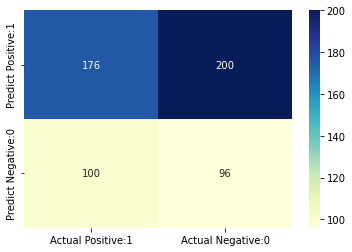

In [76]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [77]:
# Classification report to evaluate the classification model performance
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.47      0.54       376
           1       0.32      0.49      0.39       196

    accuracy                           0.48       572
   macro avg       0.48      0.48      0.47       572
weighted avg       0.53      0.48      0.49       572



In [78]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [79]:
# print classification accuracy, same as test set score & model accuracy score

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.4755


In [80]:
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.5245


In [81]:
# f1-score is always lower than accuracy measures, they embed precision and recall into their computation
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

F1 Score: 0.390
